# HUGGIN FACE + FASTAI 
#### SENTIMENT CLASSIFICATION

La libreria fastai introduce múltiples metodos para Transfer Learning, pero usa como estandar la AWD_LSTM y no incluye los modelos más avanzados basados en Transformers. 
Para poder hacer uso de los mismos, combinamos fastai con Hugging Face, que sí tiene implementados dichos modelos.

Fastai nos proporciona además Discriminative Learning Rate, Gradual unfreezing y Slanted Triangular Learning Rates.


# LIBRERIAS 

In [1]:
!pip install transformers==2.5.1
from fastai.text import *
from fastai.callbacks import *

from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig


from transformers import AdamW

from tqdm.notebook import tqdm
import seaborn as sns

     |████████████████████████████████| 501kB 4.1MB/s 
     |████████████████████████████████| 3.7MB 10.9MB/s 
     |████████████████████████████████| 890kB 54.7MB/s 
     |████████████████████████████████| 102kB 13.7MB/s 
     |████████████████████████████████| 1.1MB 52.5MB/s 
     |████████████████████████████████| 7.2MB 56.2MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=77b551748a27eb133a7823abaec914618e8a6487898635293c8f426d5a08eba4
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
  Created wheel for boto3: filename=boto3-1.16.48-py2.py3-none-any.whl size=128710 sha256=5930c9e477baa663fb56258d3a8a891a0392bb790ad2482a64c618fb69b93a20
  Stored in directory: /root/.cache/pip/wheels/29/5e/24/c13b555a2c0978dfc167c07c1f2f5e338cb44a5e8ea467ea42
Successfully built sacremoses boto3
ERROR: botocore 1.19.48 has requirement urll

# Amazon dataset preparation 

b'Skipping line 85458: expected 15 fields, saw 22\nSkipping line 91161: expected 15 fields, saw 22\n'
b'Skipping line 166123: expected 15 fields, saw 22\n'
b'Skipping line 225458: expected 15 fields, saw 22\nSkipping line 229936: expected 15 fields, saw 22\nSkipping line 259297: expected 15 fields, saw 22\n'
b'Skipping line 284728: expected 15 fields, saw 22\nSkipping line 286334: expected 15 fields, saw 22\nSkipping line 293400: expected 15 fields, saw 22\nSkipping line 294415: expected 15 fields, saw 22\nSkipping line 308150: expected 15 fields, saw 22\nSkipping line 315022: expected 15 fields, saw 22\nSkipping line 315730: expected 15 fields, saw 22\nSkipping line 316071: expected 15 fields, saw 22\nSkipping line 326729: expected 15 fields, saw 22\n'
b'Skipping line 329101: expected 15 fields, saw 22\nSkipping line 333077: expected 15 fields, saw 22\nSkipping line 377031: expected 15 fields, saw 22\nSkipping line 389496: expected 15 fields, saw 22\nSkipping line 390486: expected 15 

,star_rating,review_body,index,is_valid
0,0,I'm not sure how everyone else has such good l...,0,False
1,1,Have had my strap on my canon for about 6 mont...,1,False
2,0,the glue that holds the cap to the safety cord...,2,False
3,1,These are awesome and I love that I can just s...,3,False
4,0,I just got this charger and it won't evon char...,4,False


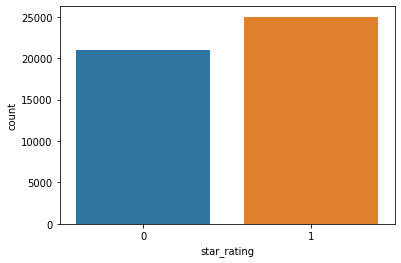

In [2]:
path = "drive/MyDrive/amazon_reviews_us_Camera_v1_00.tsv"
df = pd.read_csv(path,delimiter='\t',error_bad_lines=False)

df = df.head(100000)
df = df[['star_rating','review_body']]
df = df.dropna()
df['star_rating'] = df['star_rating'].astype(int)
df['star_rating']= np.where(df['star_rating']>=4,1,0) ##asi un poco mas balanceado 

final_true= df[df['star_rating']==1][:25000]
final_false = df[df['star_rating']==0][:21000]
df = final_true.append(final_false)
df = df.sample(frac = 1, random_state = 1)
df = df.reset_index(drop=True)
sns.countplot(df['star_rating'])

df['index'] = df.index

df['is_valid']= np.where(df['index'] < 30000 ,'False','True') #divido en train valid pero a ojo 
d = {'True': True, 'False': False}
df['is_valid']= df['is_valid'].map(d)
# df.dtypes

df.head()

In [3]:
# dividimos en train y validation set

train = df[df['is_valid']==False]
valid = df[df['is_valid']==True]

print(train.shape, valid.shape)

(30000, 4) (16000, 4)


# Main Transformers classes

En la librería Transformers, cada arquitectura de modelo está asociada con tres clases diferentes:


*   Una clase Model: para cargar o guardar un modelo pre-entrenado
*   Una clase Tokenizer: para realizar el preprocesado de los datos y hacerlo compatible con un modelo determinado
*   Una clase Configuration: para guardar la configuración de un determinado modelo. 

E.g., para usar la arquitectura BERT en clasificación de texto, tenemos que usar: 
- BertForSequenzeClassification como clase model 
- BertTokenizer como clase tokenizer
- BertConfig como clase configuration

Creamos un diccionario para poder probar diferentes modelos de manera más simple y compararlos






In [4]:
## diccionario de modelos
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

In [5]:
# Parameters
seed = 42
use_fp16 = False
bs = 16

model_type = 'roberta'
pretrained_model_name = 'roberta-base'

#model_type = 'bert'
#pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

# model_type = 'xlnet'
# pretrained_model_name = 'xlnet-base-cased'

In [6]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [7]:
# FUNCTION TO GENERATE RANDOM NUMBERS 

def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [8]:
seed = 777
seed_all(seed)

# Data Preprocessing 

## Custom Tokenizer




In [9]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len- 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len- 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens


In [10]:
transformer_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = 'roberta')
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

##Custom numericalizer

In [11]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

## Custom processor

In [12]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]


In [13]:
pad_first = False # except for XLNet
pad_idx = transformer_tokenizer.pad_token_id

In [14]:
tokens = transformer_tokenizer.tokenize('Salut c est moi, Hello it s me')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)

['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme']
[18111, 1182, 740, 3304, 7458, 118, 6, 20920, 24, 579, 162]


['Sal', 'ut', 'Ġc', 'Ġest', 'Ġmo', 'i', ',', 'ĠHello', 'Ġit', 'Ġs', 'Ġme']

# Setting up the DataBunch

In [15]:
databunch = (TextList.from_df(train, cols='review_body', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols ='star_rating')
             .add_test(valid)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

/usr/local/lib/python3.6/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [16]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()

[CLS] token : <s>
[SEP] token : </s>
[PAD] token : <pad>


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  idx_min = (t != self.pad_idx).nonzero().min()


text,target
"<s> ĠThe ĠPanasonic ĠNo ctic ron Ġis Ġprobably Ġthe Ġjewel Ġof Ġthe ĠMFT Ġlenses , Ġor Ġat Ġleast Ġthe Ġones Ġthat ĠI Ġhave Ġtried . ĠI Ġam Ġa Ġhuge Ġfan Ġof Ġthe ĠPanasonic ĠLeica Ġ25 mm ĠF / 1 . 4 , Ġbut ĠI Ġreally Ġdo Ġthink Ġthe ĠNo ctic ron Ġhas Ġit Ġbeat . ĠAt Ġminimum Ġit Ġfeatures Ġa Ġmanual Ġaperture Ġring Ġplus Ġimage Ġstabilization Ġ( which Ġalone Ġis",1
"<s> ĠThis Ġreview Ġis Ġfor Ġa ĠSamsung ĠGalaxy ĠS 4 Ġunder Ġ4 . 2 . 0 Ġon Ġthe Ġtechnical Ġside .< br Ġ/ >< br Ġ/> You Ġknow , ĠI Ġam Ġthe Ġkind Ġof Ġperson Ġthat Ġhates Ġphones Ġwhere Ġeverything Ġhas Ġto Ġbe Ġtouch Ġscreen . ĠSure Ġit Ġprovides Ġsome Ġpros , Ġbut Ġnothing Ġbeats Ġhaving Ġphysical Ġbuttons Ġover Ġtouch Ġbuttons .< br Ġ/ >< br Ġ/> Well , Ġthis",0
"<s> ĠFirst , ĠI Ġdid Ġreceive Ġthis ĠLens Ġkit Ġfree Ġfor Ġthe Ġpurpose Ġof Ġtesting Ġand Ġreview . ĠWhile ĠI Ġrealize Ġthat Ġa Ġreview Ġof Ġa Ġfree Ġproduct Ġis Ġfundamentally Ġdifferent Ġfrom Ġa Ġreview Ġof Ġa Ġproduct Ġfor Ġwhich Ġone Ġhas Ġpaid Ġhis Ġown Ġmoney , ĠI Ġdo Ġtake Ġthe Ġreview Ġprocess Ġseriously Ġand Ġam Ġthus Ġhopeful Ġthat Ġmy Ġobservations Ġand Ġimpressions Ġwill Ġindeed Ġbe Ġhelpful Ġin Ġyour Ġdecision Ġmaking",1
"<s> ĠI Ġpurchased Ġthis Ġcamera Ġjust Ġover Ġa Ġyear Ġago . ĠThe Ġreason ĠI Ġchose Ġthis Ġit , Ġwas Ġbecause Ġit Ġhad Ġthe Ġability Ġto Ġtake Ġa Ġphoto Ġwhen Ġthere Ġwas Ġmotion Ġdetected Ġand Ġthen Ġsend Ġit Ġto Ġmy ĠGmail Ġas Ġan Ġe - mail . Ġ ĠThe Ġcamera Ġwas Ġrelatively Ġeasy Ġto Ġset Ġup Ġand Ġthough Ġit Ġexperiences Ġfrequent Ġloss Ġof Ġconnectivity ; Ġthe Ġcamera Ġdid Ġwhat ĠI Ġneeded",0
"<s> ĠI Ġchanged Ġmy Ġreview Ġof Ġthis Ġcamera Ġfrom Ġa Ġ5 Ġto Ġa Ġ1 . ĠThe Ġreason Ġfor Ġthis Ġis Ġbecause Ġis Ġbecause Ġeven Ġthough Ġthe Ġcamera Ġit 's Ġself Ġis Ġa Ġpretty Ġdecent Ġcamera , Ġand Ġeven Ġviewing Ġthe Ġcamera Ġvia Ġthe ĠAndroid Ġapp Ġworks Ġpretty Ġgood Ġtoo ... Ġthe ĠMA IN Ġthing ĠI Ġwanted Ġthis Ġcamera Ġfor Ġwas Ġso ĠI Ġwould Ġbe Ġnotified Ġwhen Ġmotion Ġor Ġmy Ġexternal",0


In [17]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = databunch.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

[CLS] id : 0
[SEP] id : 2
[PAD] id : 1
Batch shape :  torch.Size([16, 512])
tensor([[    0,    38,   269,  ...,  3809, 48709,     2],
        [    0,   345,    32,  ...,    65,   821,     2],
        [    0,    38,   829,  ...,   117,   701,     2],
        ...,
        [    0,    38,  2162,  ...,     1,     1,     1],
        [    0,   374,   127,  ...,     1,     1,     1],
        [    0,    38,   348,  ...,     1,     1,     1]])


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


# Custom Model

In [18]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]   
        return logits

In [19]:
## multiclass classification 5 labels 
## binary classification 2 labels ?!


config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 5
config.use_bfloat16 = use_fp16
print(config)



RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "do_sample": false,
  "eos_token_id": 2,
  "eos_token_ids": null,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-05,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_beams": 1,
  "num_hidden_layers": 12,
  "num_labels": 5,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": 1,
  "pruned_heads": {},
  "repetition_penalty": 1.0,
  "temperature": 1.0,
  "top_k": 50,
  "top_p": 1.0,
  "torchscript": false,
  "type_vocab_

In [20]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 5)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

# Learner: Custom Optimizer / Custom Metric  

In [21]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

# Discriminative Fine-Tuning and Gradual Unfreezing

In [22]:
print(learner.model)

CustomTransformerModel(
  (transformer): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(i

In [23]:
# For DistilBERT
# list_layers = [learner.model.transformer.distilbert.embeddings,
#                learner.model.transformer.distilbert.transformer.layer[0],
#                learner.model.transformer.distilbert.transformer.layer[1],
#                learner.model.transformer.distilbert.transformer.layer[2],
#                learner.model.transformer.distilbert.transformer.layer[3],
#                learner.model.transformer.distilbert.transformer.layer[4],
#                learner.model.transformer.distilbert.transformer.layer[5],
#                learner.model.transformer.pre_classifier]

# For xlnet-base-cased
# list_layers = [learner.model.transformer.transformer.word_embedding,
#               learner.model.transformer.transformer.layer[0],
#               learner.model.transformer.transformer.layer[1],
#               learner.model.transformer.transformer.layer[2],
#               learner.model.transformer.transformer.layer[3],
#               learner.model.transformer.transformer.layer[4],
#               learner.model.transformer.transformer.layer[5],
#               learner.model.transformer.transformer.layer[6],
#               learner.model.transformer.transformer.layer[7],
#               learner.model.transformer.transformer.layer[8],
#               learner.model.transformer.transformer.layer[9],
#               learner.model.transformer.transformer.layer[10],
#               learner.model.transformer.transformer.layer[11],
#               learner.model.transformer.sequence_summary]

# For roberta-base
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]

In [24]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)

Learner split in 14 groups
[Sequential(
  (0): Embedding(50265, 768, padding_idx=1)
  (1): Embedding(514, 768, padding_idx=1)
  (2): Embedding(1, 768)
  (3): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=768, out_features=3072, bias=True)
  (8): Linear(in_features=3072, out_features=768, bias=True)
  (9): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2)

## Train

In [25]:
learner.save('untrain')

In [26]:
seed_all(seed)
learner.load('untrain');

In [27]:
learner.freeze_to(-1)

In [28]:
learner.summary()

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [512, 768]           38,603,520 False     
______________________________________________________________________
Embedding            [512, 768]           394,752    False     
______________________________________________________________________
Embedding            [512, 768]           768        False     
______________________________________________________________________
LayerNorm            [512, 768]           1,536      False     
______________________________________________________________________
Dropout              [512, 768]           0          False     
______________________________________________________________________
Linear               [512, 768]           590,592    False     
______________________________________________________________________
Linear               [512, 768]           590,592    False     
_______________________________________

In [29]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.58E-04
Min loss divided by 10: 3.63E-04


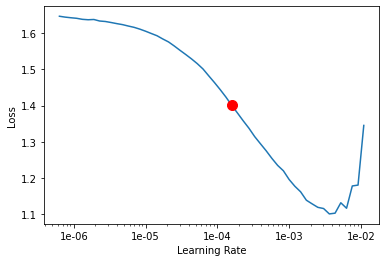

In [30]:
learner.recorder.plot(skip_end=10,suggestion=True)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.478697,0.435240,0.835667,0.164333,01:30


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


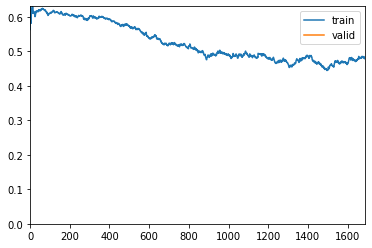

In [32]:
learner.fit_one_cycle(1,max_lr=1e-04,moms=(0.8,0.7))

In [33]:
learner.save('first_cycle')

In [34]:
seed_all(seed)
learner.load('first_cycle');

In [35]:
learner.freeze_to(-2)

In [36]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.00E-03
Min loss divided by 10: 3.31E-07


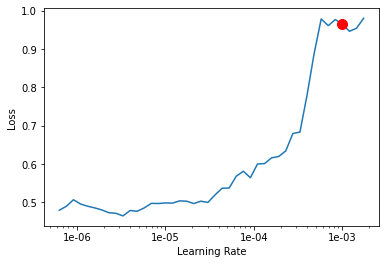

In [37]:
learner.recorder.plot(skip_end=10,suggestion=True)


In [38]:
lr = 8.1e-4

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.276593,0.257984,0.897333,0.102667,01:53


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


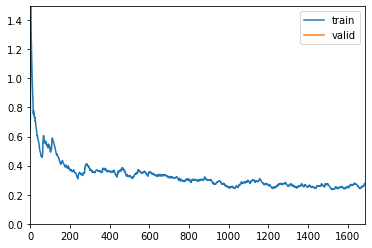

In [39]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [40]:
learner.save('second_cycle')

In [41]:
seed_all(seed)
learner.load('second_cycle');


In [42]:
learner.freeze_to(-3)

In [43]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-06
Min loss divided by 10: 3.31E-07


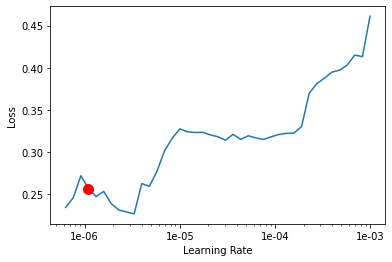

In [44]:
learner.recorder.plot(skip_end=10,suggestion=True)

In [45]:
lr = 8.8e-7

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.282076,0.258360,0.898000,0.102000,02:08


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


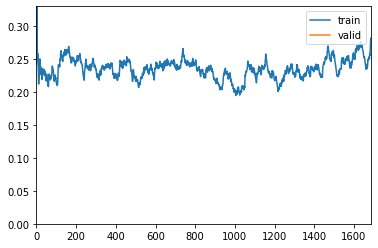

In [46]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [47]:
learner.save('third_cycle')

In [48]:
seed_all(seed)
learner.load('third_cycle');

In [49]:
learner.unfreeze()

In [50]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-06
Min loss divided by 10: 3.31E-07


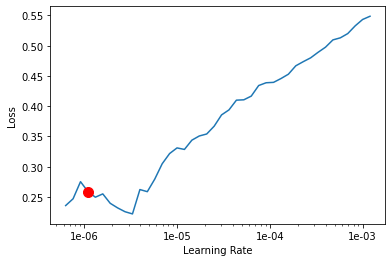

In [51]:
learner.recorder.plot(skip_end=10,suggestion=True)

In [52]:
lr = 1e-6

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.265379,0.237871,0.908333,0.091667,04:58
1,0.209746,0.233059,0.908667,0.091333,05:28


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


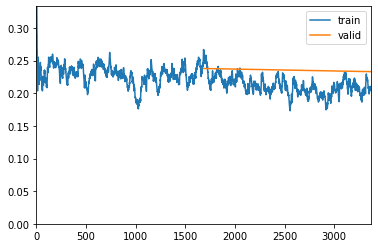

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [53]:
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [54]:
learner.predict('This is the best product')

(Category tensor(1),
 tensor(1),
 tensor([1.1759e-02, 9.8824e-01, 1.0036e-12, 5.1453e-12, 2.2505e-12]))

In [55]:
learner.predict('This is the worst camera')

(Category tensor(0),
 tensor(0),
 tensor([9.8626e-01, 1.3743e-02, 5.8580e-07, 3.7964e-07, 5.2140e-07]))

# Export Learner

In [60]:
learner.export(file = 'transformer.pkl');


In [62]:
path = '/drive/MyDrive'
#export_learner = load_learner(path, file = 'transformer.pkl')